In [12]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# loading the directories
training_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test/train/'
validation_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test/valid/'
test_dir = '/content/drive/MyDrive/Colab/Data/train_valid_test/test/'

In [3]:
# useful for getting number of files
image_files = glob(training_dir + '/*/*.jp*g')
valid_image_files = glob(validation_dir + '/*/*.jp*g')

In [4]:
# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 3


In [5]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16
#from keras.preprocessing import image

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results.

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
# num_classes = 3   # B2, B5, B6
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# Image Augmentation

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 64, class_mode = 'categorical')

Found 7698 images belonging to 3 classes.
Found 954 images belonging to 3 classes.


In [8]:
# The labels are stored in class_indices in dictionary form.
# checking the labels
training_generator.class_indices

{'B2': 0, 'B5': 1, 'B6': 2}

In [9]:
history = model.fit(training_generator,
                  #  steps_per_epoch = 7698,  # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results.
                   epochs = 50,  # change this for better results
                   validation_data = validation_generator,)
                  #  validation_steps = 954)  # this should be equal to total number of images in validation set.

Epoch 1/2
154/154 [==============================] - 4797s 31s/step - loss: 0.6379 - accuracy: 0.7167 - val_loss: 0.4917 - val_accuracy: 0.7809
Epoch 2/2
154/154 [==============================] - 4790s 31s/step - loss: 0.4627 - accuracy: 0.7898 - val_loss: 0.7305 - val_accuracy: 0.6855


In [21]:
# Lưu mô hình cùng với trạng thái của trình tối ưu hóa
model.save('/content/drive/MyDrive/Colab/Model/vgg16_model.keras')

In [11]:
# In độ chính xác đào tạo và xác thực
print('Training Accuracy = ' + str(history.history['accuracy']))
print('Validation Accuracy = ' + str(history.history['val_accuracy']))

Training Accuracy = [0.7166796326637268, 0.7898155450820923]
Validation Accuracy = [0.7809224128723145, 0.6855345964431763]


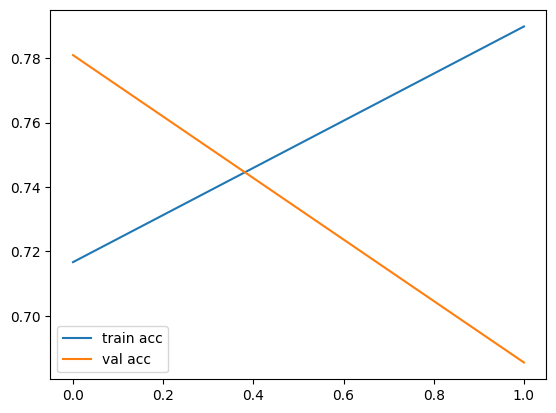

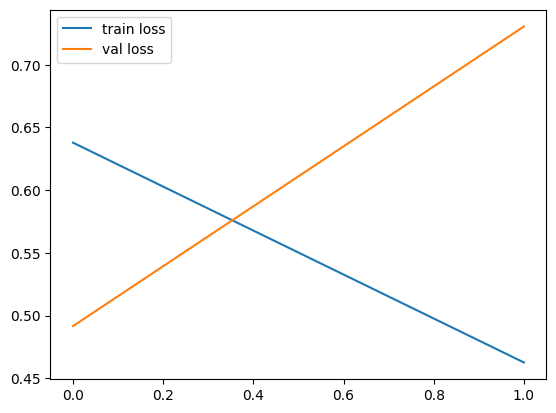

In [12]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [3]:
from keras.models import load_model

# Tải mô hình đã lưu
model = load_model('/content/drive/MyDrive/Colab/Model/vgg16_model.keras')

In [7]:
x_test=[]
test_path = '/content/drive/MyDrive/Colab/Data/train_valid_test/test'

import os, cv2
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        img_arr=img_arr/255.0
        x_test.append(img_arr)

test_x=np.array(x_test)

from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
test_y=test_set.classes

Found 1491 images belonging to 3 classes.


In [8]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)

47/47 [==============================] - 823s 17s/step


In [9]:
y_pred_=np.argmax(y_pred, axis=1)

In [10]:
print(y_pred.shape, y_pred_.shape, test_y.shape)

(1491, 3) (1491,) (1491,)


In [11]:
#get classification report
print(classification_report(y_pred_, test_y))

#get confusion matrix
print(confusion_matrix(y_pred_, test_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       306
           1       0.39      0.19      0.26      1004
           2       0.34      0.92      0.49       181

    accuracy                           0.24      1491
   macro avg       0.24      0.37      0.25      1491
weighted avg       0.30      0.24      0.23      1491

[[  1 305   0]
 [482 192 330]
 [ 14   0 167]]


In [33]:
import cv2
# Tải ảnh vào một mảng NumPy
# image = cv2.imread('/content/drive/MyDrive/Colab/Data/train_valid_test/test/B5/B5_0_z5021000001378_1e7342c46548eb446b5a389f07bf35d1.jpg')
image = cv2.imread('/content/drive/MyDrive/Colab/Data/train_valid_test/test/B6/B6_4_Image_142030.jpg')
image = cv2.resize(image, (224, 224))

# Chuẩn hóa ảnh
image = image / 255.0

# Thêm một chiều lô vào ảnh
image = np.expand_dims(image, axis=0)

# Dự đoán trên ảnh
predictions = model.predict(image)

# In các xác suất cho mỗi lớp
print(predictions)

1/1 [==============================] - 1s 694ms/step
[[6.071948e-04 9.301508e-01 6.924201e-02]]
